#load requirements

In [8]:
import os
#pandas
import pandas as pd
#numpy
import numpy as np
#matplotlib
import matplotlib.pyplot as plt
import math
%matplotlib inline
#seaborn
import seaborn as sns
#sklearn
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay

load dataset

In [85]:
dataset = pd.read_csv('./pima_diabetes/diabetes.csv')

Analyse Dataset rows and columns

Number of rows and columns

In [86]:
print (dataset.shape)

(768, 9)


check for any missing values

In [87]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


No values are missing.

sample of top 10 columns in dataset

In [88]:
print (dataset.head(10))

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96              0        0   0.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   2

Looks like the data has many continuous variables. Lets find out the statistical measures.

In [89]:
dataset[["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","Age"]].describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,81.000000


Looking at the minimum row in the table above, all columns except age have 0 as minimum which means some of the values are invalid in the table. This should be kept in mind when dealing with such columns.

Graph showing number of patients with diabetes('1' in graph) and those without diabetes('0' in graph)

<AxesSubplot:xlabel='Outcome', ylabel='count'>

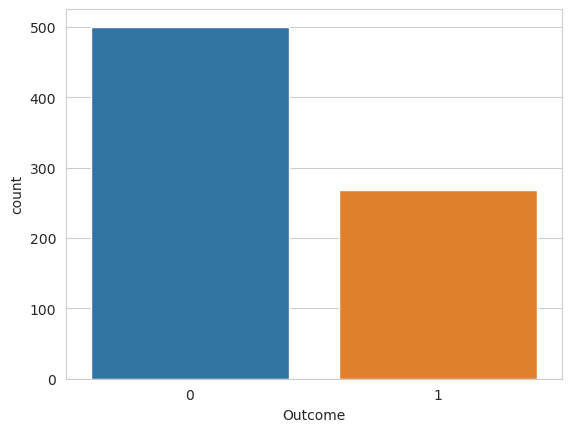

In [90]:
sns.countplot(x="Outcome", data=dataset)

In [91]:
print (f"number of patients with diabetes:{dataset['Outcome'].value_counts()[1]}")

number of patients with diabetes:268


In [92]:
print (f"number of patients without diabetes:{dataset['Outcome'].value_counts()[0]}")

number of patients without diabetes:500


Age distributions of diabetics and non-diabetics

Text(0.5, 1.0, 'Population')

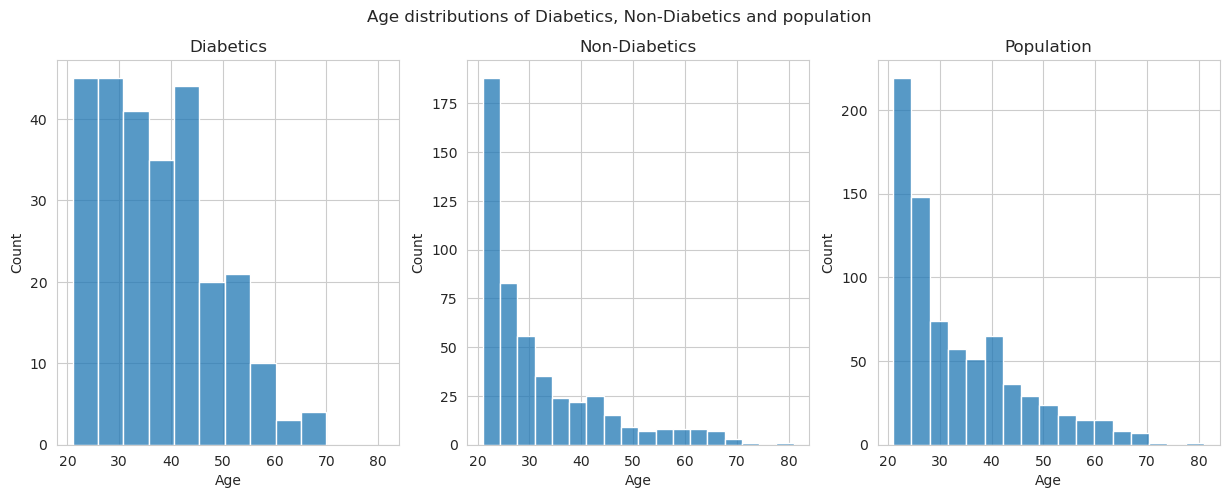

In [55]:
fig, axes = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=False)
fig.suptitle("Age distributions of Diabetics, Non-Diabetics and population")
sns.histplot(ax=axes[0],data=dataset[dataset["Outcome"]==1], x="Age")
axes[0].set_title("Diabetics")
sns.histplot(ax=axes[1],data=dataset[dataset["Outcome"]==0], x="Age")
axes[1].set_title("Non-Diabetics")
sns.histplot(ax=axes[2],data=dataset, x="Age")
axes[2].set_title("Population")

In [57]:
def kdp(column):
    fig, axes = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)
    fig.suptitle(f"{column} of Diabetics, Non-Diabetics and population")
    sns.kdeplot(ax=axes[0],data=dataset[(dataset["Outcome"]==1) & (dataset[column] != 0)], x=column)
    axes[0].set_title("Diabetics")
    sns.kdeplot(ax=axes[1],data=dataset[(dataset["Outcome"]==0) & (dataset[column]!=0)], x=column)
    axes[1].set_title("Non-Diabetics")
    sns.kdeplot(ax=axes[2],data=dataset[dataset[column]!=0], x=column)
    axes[2].set_title("Population")

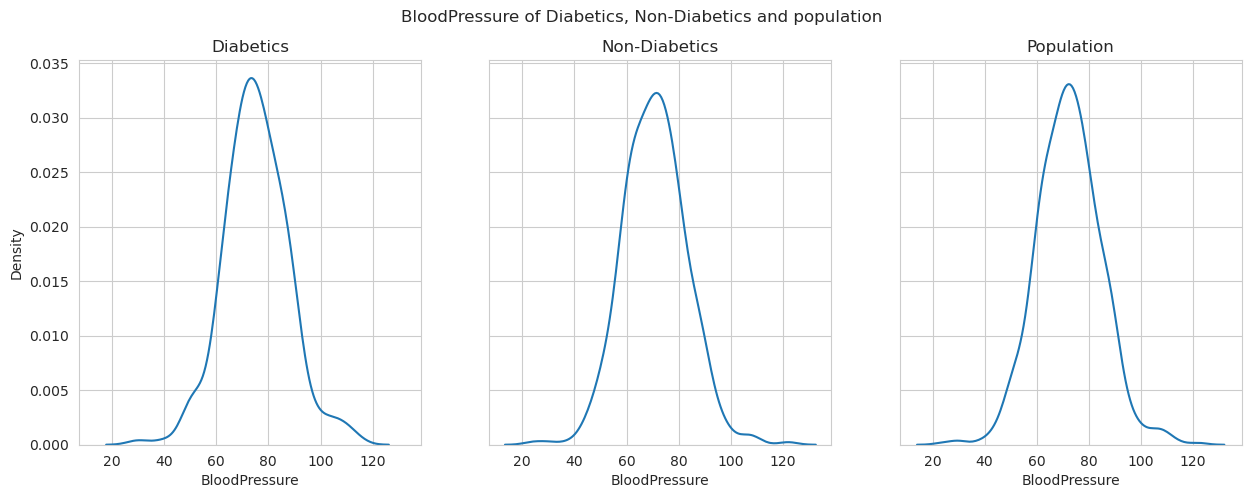

In [58]:
kdp("BloodPressure")

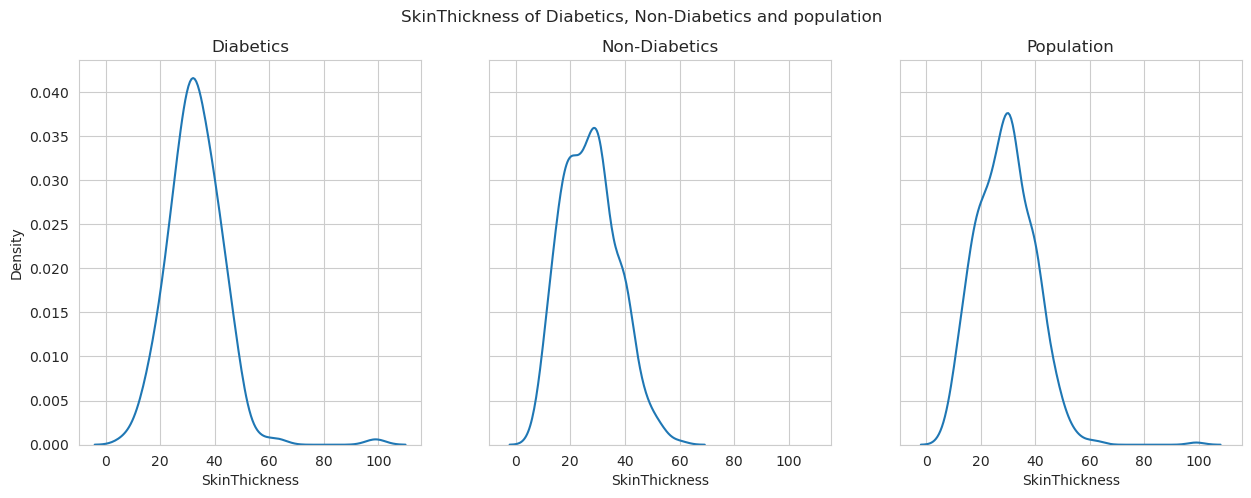

In [59]:
kdp("SkinThickness")

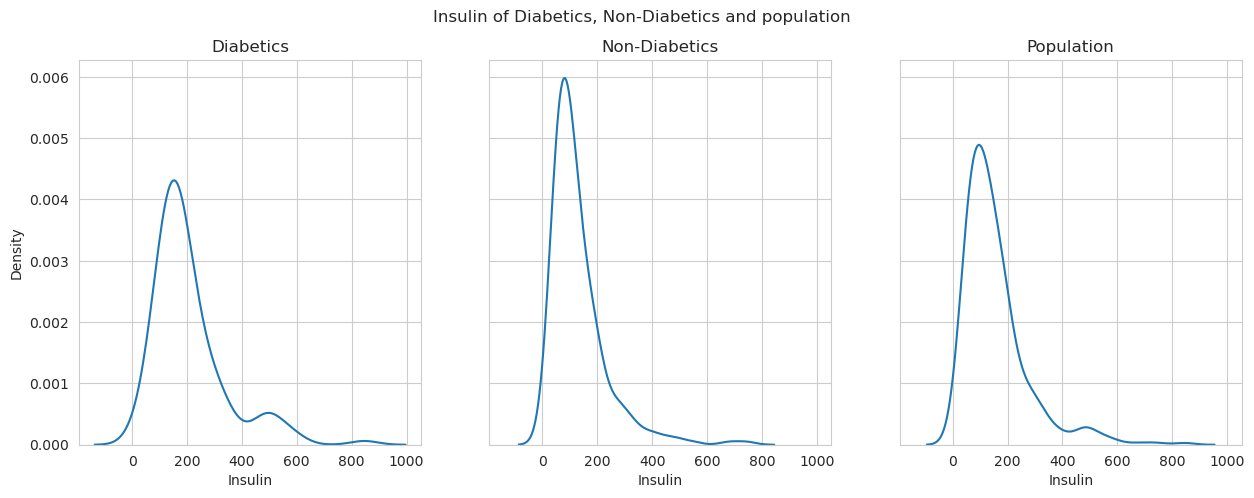

In [60]:
kdp("Insulin")

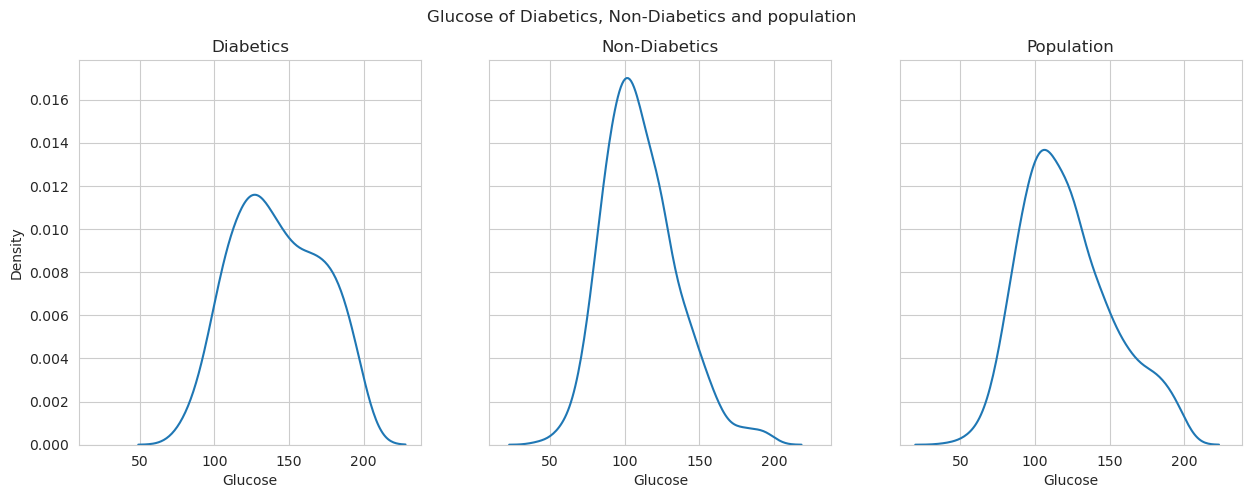

In [61]:
kdp("Glucose")

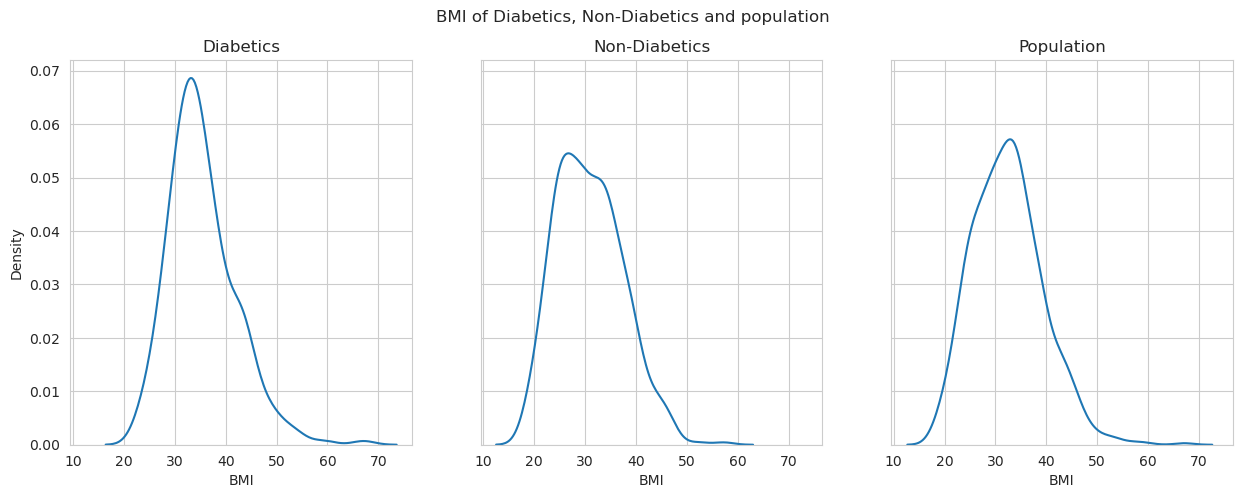

In [62]:
kdp("BMI")

Blood pressure seems to peak at same level in both diabetics and non diabetics. Skin thickness, Insulin, Glucose and BMI have different peaks in diabetics and non diabetics. Interestingly  BMI of study population in more than that of diabetics.

Before we begin logistic regression, I would like to remove all zeros from the table to prevent the problem of outliers.

In [13]:
newDataset = dataset[(dataset["SkinThickness"] != 0) & (dataset["Insulin"] != 0) & (dataset["Glucose"] != 0) & (dataset["BloodPressure"] != 0) & 
                     (dataset["BMI"] != 0)]

In [10]:
newDataset.shape

(392, 9)

Looks like our data is reduced almost by half!

In [16]:
X = newDataset.drop("Outcome", axis=1)
y = newDataset["Outcome"]

In [49]:
def splitplot(f):
    ss = np.linspace(0.1,0.9,90)
    sen = np.array([])
    spec = np.array([])
    acc = np.array([])
    maxsen = {'max-sensitivity':0,'split-size':0}
    maxspec = {'max-specificity':0,'split-size':0 }
    maxacc = {'max-accuracy':0,'split-size':0}
    for ele in ss:
        currentSensitivity = f(X,y,ele)['sensitivity']
        currentSpecificity = f(X,y,ele)['specificity']
        currentAccuracy = f(X,y,ele)['accuracy']
        if np.any(sen):
            if currentSensitivity > maxsen['max-sensitivity']:
                maxsen['max-sensitivity']=currentSensitivity
                maxsen['split-size'] = ele
        if np.any(spec):
            
            if currentSpecificity > maxspec['max-specificity']:
                maxspec['max-specificity'] = currentSpecificity
                maxspec['split-size'] = ele
                
        if np.any(acc):
            if currentAccuracy >= maxacc['max-accuracy']:
                maxacc = {'max-accuracy':currentAccuracy, 'split-size':ele}
        sen = np.concatenate((sen,np.array([currentSensitivity])))
        spec = np.concatenate((spec,np.array([currentSpecificity])))
        acc = np.concatenate((acc,np.array([currentAccuracy])))
    print(maxsen)
    print(maxspec)
    print(maxacc)
    fig, axes = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)
    fig.suptitle("sensitivity, specificity and accuracy with various test split sizes")
    axes[0].set_title("Sensitivity")
    axes[1].set_title("Specificity")
    axes[2].set_title("accuracy")
    axes[0].plot(ss, sen)
    axes[1].plot(ss, spec)
    axes[2].plot(ss, acc)
    return ([maxsen, maxspec, maxacc])
    
   

Logistic regression

In [17]:
def logreg(x,y, split_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=99)
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn,fp,fn,tp = cm.ravel()
    sensitivity = tp*100/(tp+fn)
    specificity = tn*100/(tn+fp)
    accuracy = (tp+tn)*100/(tp+tn+fn+fp)
    return ({'sensitivity':sensitivity, 'specificity':specificity, 'accuracy':accuracy})

{'max-sensitivity': 80.95238095238095, 'split-size': 0.12696629213483146}
{'max-specificity': 100.0, 'split-size': 0.10898876404494383}
{'max-accuracy': 91.48936170212765, 'split-size': 0.11797752808988765}


[{'max-sensitivity': 80.95238095238095, 'split-size': 0.12696629213483146},
 {'max-specificity': 100.0, 'split-size': 0.10898876404494383},
 {'max-accuracy': 91.48936170212765, 'split-size': 0.11797752808988765}]

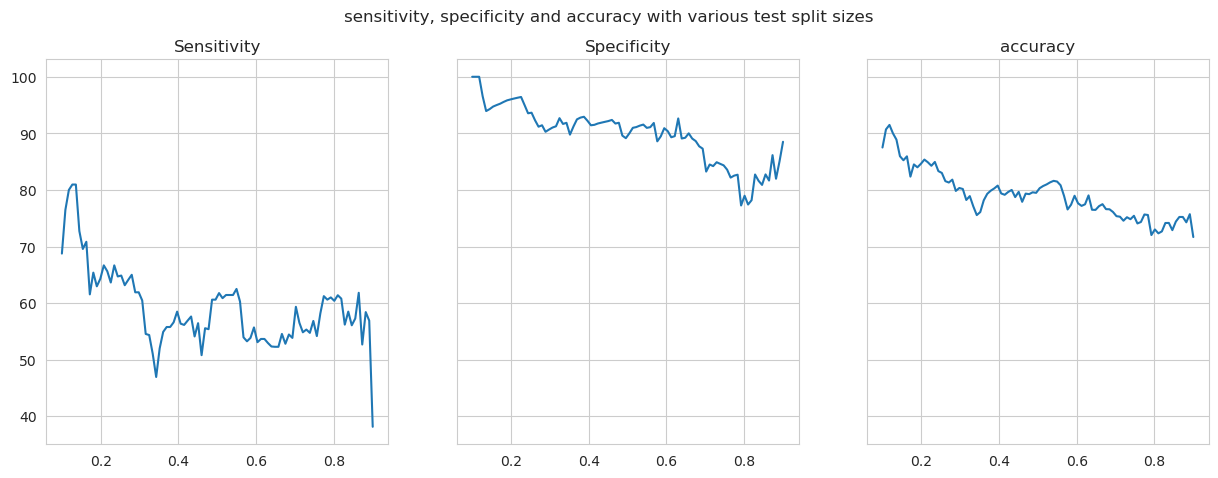

In [93]:
splitplot(logreg)

Support Vector Model(SVM)

In [19]:
def svmodel(x,y,split_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=99)
    st_x = StandardScaler()
    x_train_svm = st_x.fit_transform(X_train)
    x_test_svm = st_x.transform(X_test)
    classifier = SVC(kernel='linear', random_state=99)
    classifier.fit(x_train_svm, y_train)
    y_pred = classifier.predict(x_test_svm)
    cm = confusion_matrix(y_test, y_pred)
    tn,fp,fn,tp = cm.ravel()
    sensitivity = tp*100/(tp+fn)
    specificity = tn*100/(tn+fp)
    accuracy = (tp+tn)*100/(tp+tn+fn+fp)
    return ({'sensitivity':sensitivity, 'specificity':specificity, 'accuracy':accuracy})

{'max-sensitivity': 76.19047619047619, 'split-size': 0.12696629213483146}
{'max-specificity': 100.0, 'split-size': 0.10898876404494383}
{'max-accuracy': 89.36170212765957, 'split-size': 0.11797752808988765}


[{'max-sensitivity': 76.19047619047619, 'split-size': 0.12696629213483146},
 {'max-specificity': 100.0, 'split-size': 0.10898876404494383},
 {'max-accuracy': 89.36170212765957, 'split-size': 0.11797752808988765}]

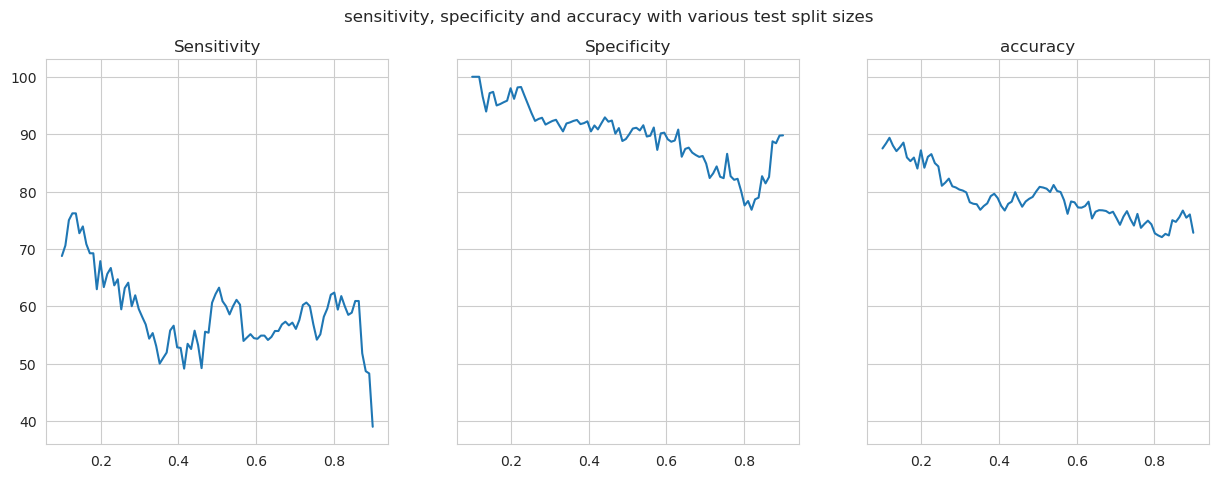

In [94]:
splitplot(svmodel)

K-Means clustering
This model simply groups data into different clusters

In [21]:
def kmd(data, nclusters, x_plot, y_plot):
    kmeans = KMeans(n_clusters=nclusters, random_state=20).fit(data)
    data['cluster'] = kmeans.labels_
    sns.set_style('whitegrid')
    sns.lmplot(x=x_plot, y=y_plot, data=data, hue='cluster', palette='coolwarm', height=6, fit_reg=False)

SkinThickness vs Glucose variying with number of clusters

number of clusters : 2

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)


In [25]:
X_train_km = X_train

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


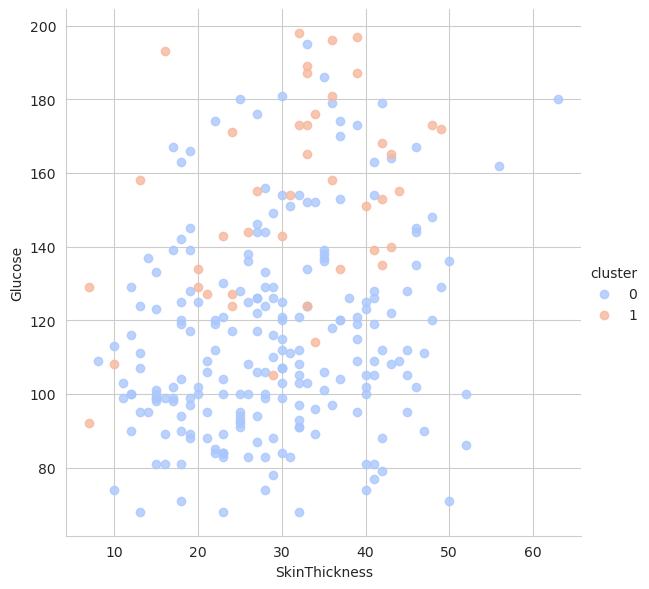

In [26]:
kmd(X_train_km, 2, "SkinThickness", "Glucose")

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


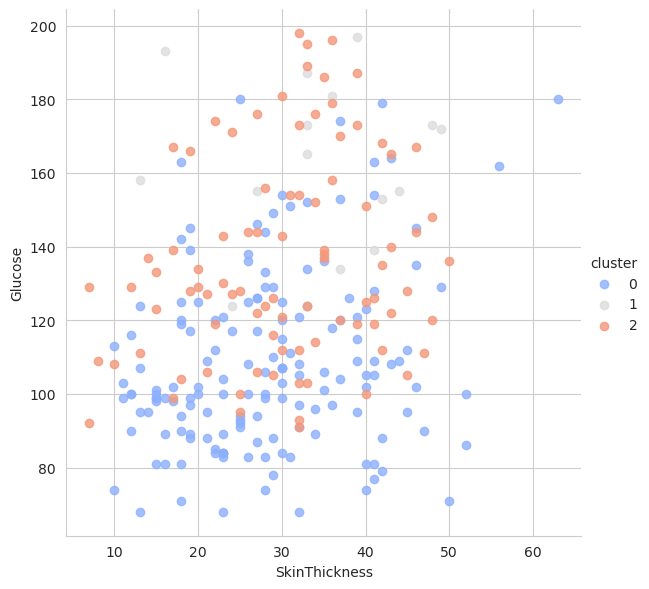

In [27]:
kmd(X_train_km, 3, "SkinThickness", "Glucose")

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


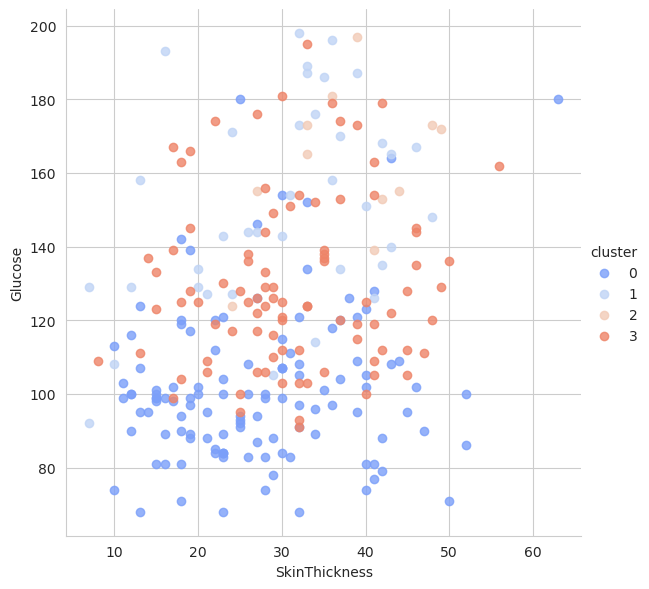

In [28]:
kmd(X_train_km, 4, "SkinThickness", "Glucose")

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


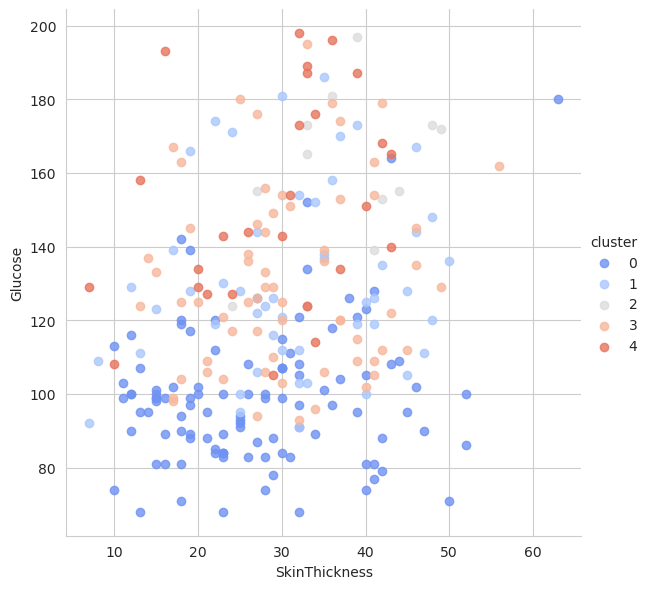

In [29]:
kmd(X_train_km, 5, "SkinThickness", "Glucose")

From the above plots it is clear that best cluster seperation occurs at k=2(2 clusters)

Insulin vs Glucose

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


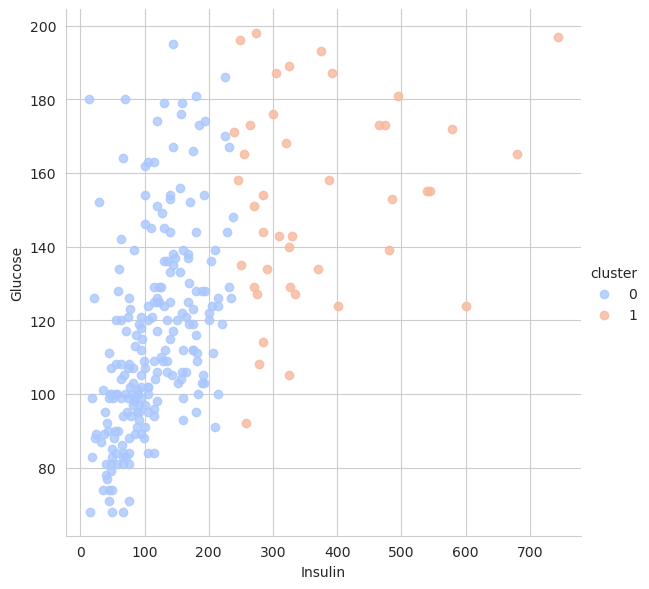

In [30]:
kmd(X_train_km, 2, "Insulin", "Glucose")

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


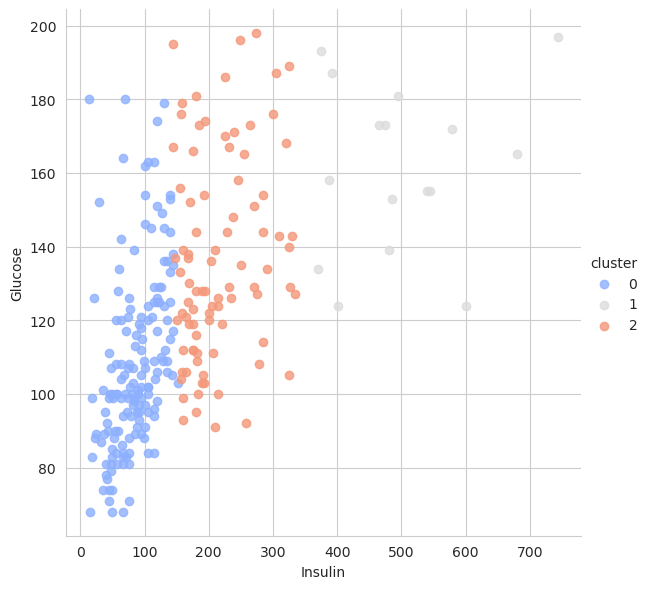

In [31]:
kmd(X_train_km, 3, "Insulin", "Glucose")

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


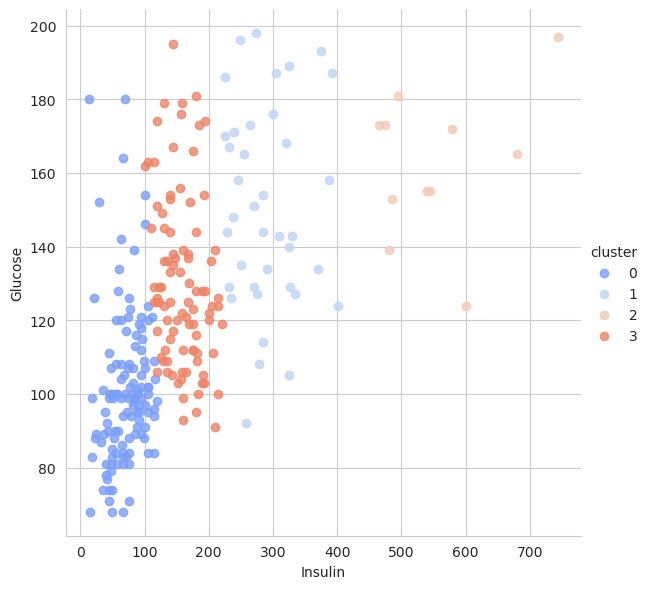

In [32]:
kmd(X_train_km, 4, "Insulin", "Glucose")

Looks like there is linear corelation between insulin and glucose

Insulin vs SkinThickness

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


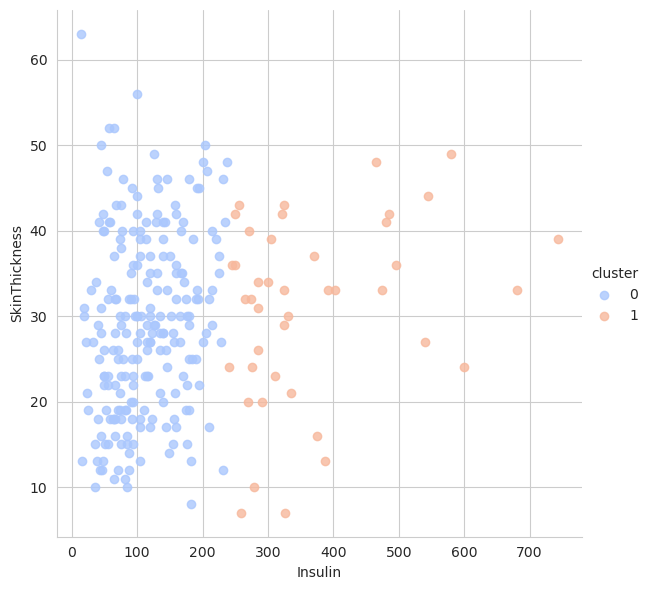

In [33]:
kmd(X_train_km, 2, "Insulin", "SkinThickness")

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


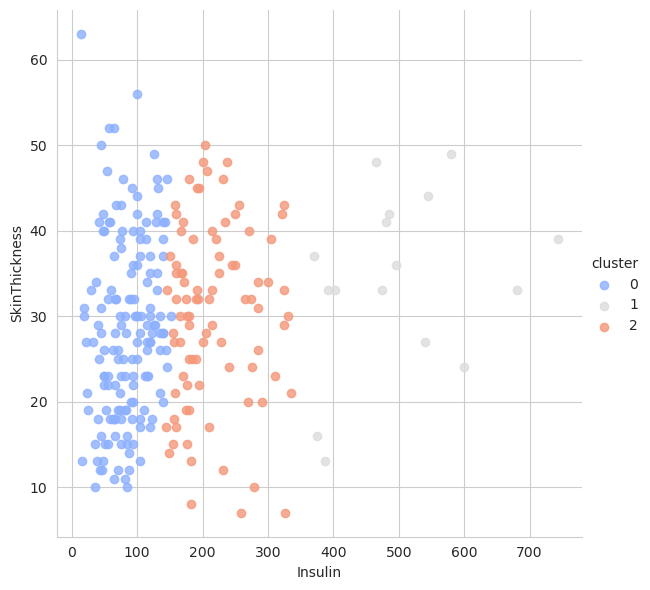

In [34]:
kmd(X_train_km, 3, "Insulin", "SkinThickness")

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


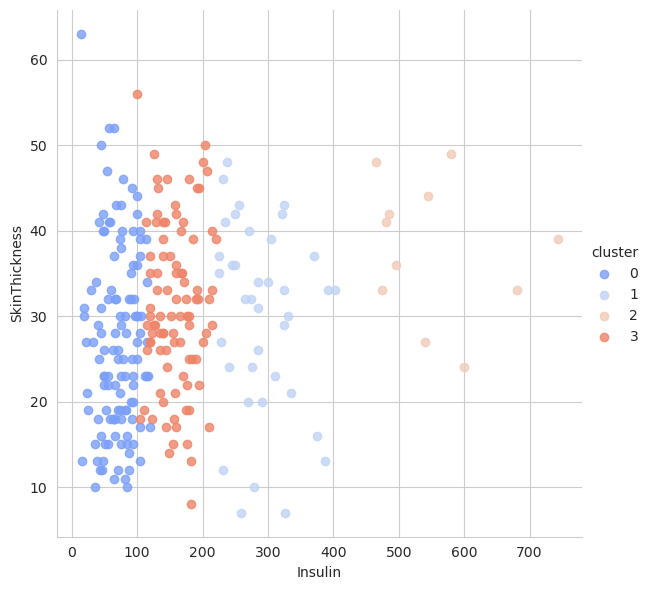

In [35]:
kmd(X_train_km, 4, "Insulin", "SkinThickness")

Looks like there is no correlation between insulin and skinThickness but the clusters are well seperated.

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


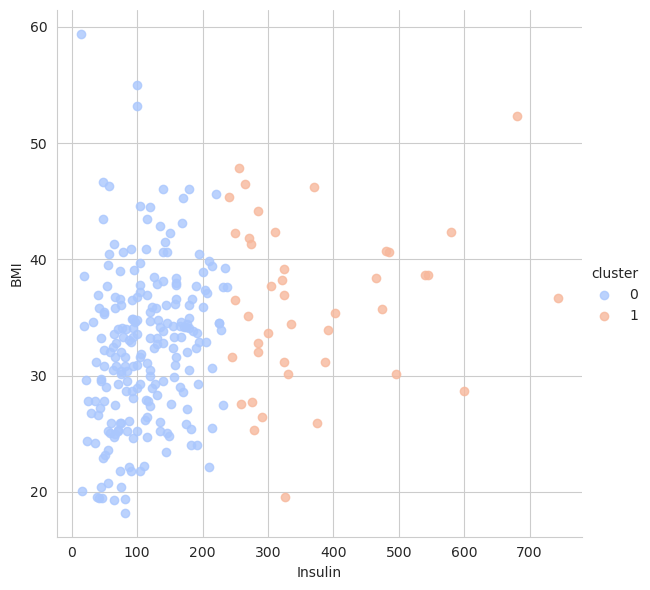

In [36]:
kmd(X_train_km, 2, "Insulin", "BMI")

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


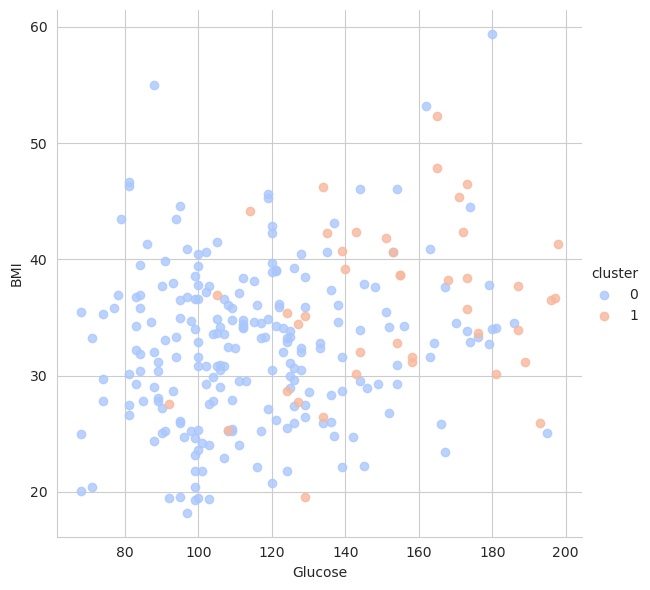

In [37]:
kmd(X_train_km, 2, "Glucose", "BMI")

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


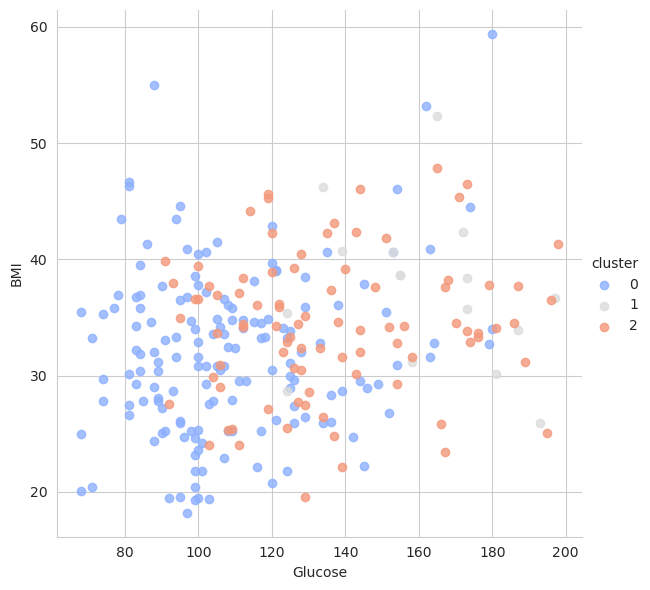

In [38]:
kmd(X_train_km, 3, "Glucose", "BMI")

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


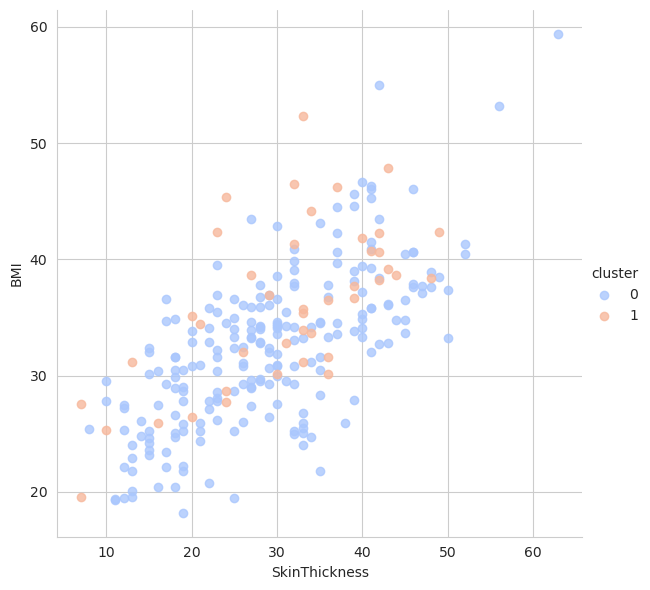

In [39]:
kmd(X_train_km, 2, "SkinThickness", "BMI")

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


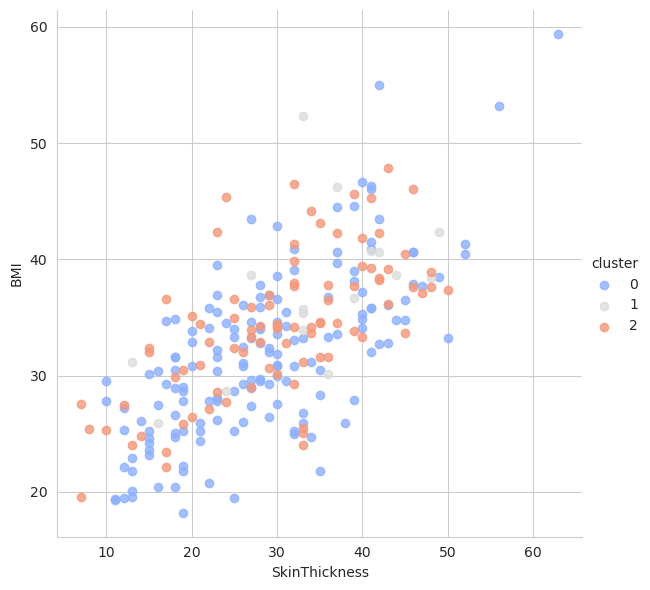

In [40]:
kmd(X_train_km, 3, "SkinThickness", "BMI")

Looks like clusters are not seperated with respect to SkinThickness and BMI

From above graphs, it is clear that cluster size 2 has best seperation. And can be used to classify patients into low risk and high risk for Diabetes

Decision Tree

In [41]:
def dt(x,y,split_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=99)
    dt = DecisionTreeClassifier(random_state=0)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn,fp,fn,tp = cm.ravel()
    sensitivity = tp*100/(tp+fn)
    specificity = tn*100/(tn+fp)
    accuracy = (tp+tn)*100/(tp+tn+fn+fp)
    return ({'sensitivity':sensitivity, 'specificity':specificity, 'accuracy':accuracy})

{'max-sensitivity': 75.0, 'split-size': 0.16292134831460675}
{'max-specificity': 92.5925925925926, 'split-size': 0.21685393258426966}
{'max-accuracy': 83.60655737704919, 'split-size': 0.15393258426966294}


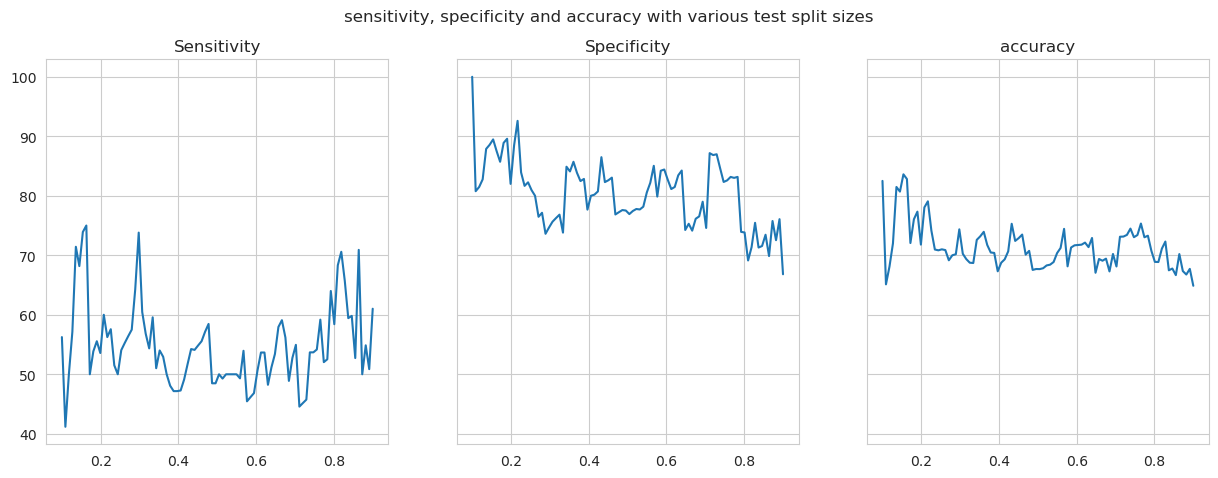

In [42]:
splitplot(dt)

Random Forest

In [43]:
def rf(X,y,split_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=99)
    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn,fp,fn,tp = cm.ravel()
    sensitivity = tp*100/(tp+fn)
    specificity = tn*100/(tn+fp)
    accuracy = (tp+tn)*100/(tp+tn+fn+fp)
    return ({'sensitivity':sensitivity, 'specificity':specificity, 'accuracy':accuracy})

{'max-sensitivity': 85.71428571428571, 'split-size': 0.12696629213483146}
{'max-specificity': 95.23809523809524, 'split-size': 0.17191011235955056}
{'max-accuracy': 90.0, 'split-size': 0.12696629213483146}


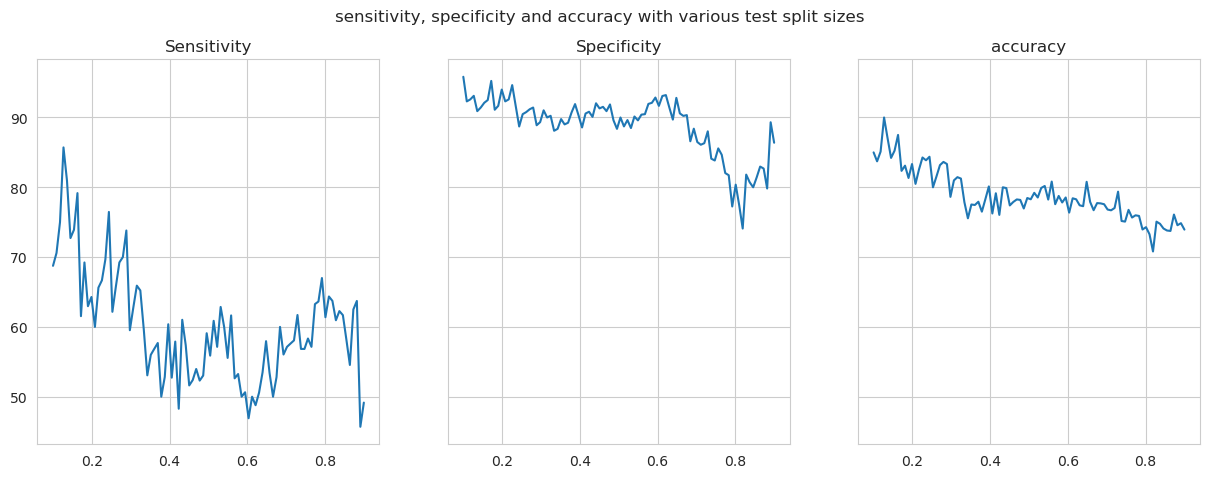

In [44]:
splitplot(rf)

K-Nearest-Neighbors (KNN)

In [45]:
def knm(k):
    def knnmodel(X,y,split_size):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=99)
        neigh = KNeighborsClassifier(n_neighbors = k)
        neigh.fit(X_train, y_train)
        y_pred = neigh.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        tn,fp,fn,tp = cm.ravel()
        sensitivity = tp*100/(tp+fn)
        specificity = tn*100/(tn+fp)
        accuracy = (tp+tn)*100/(tp+tn+fn+fp)
        return ({'sensitivity':sensitivity, 'specificity':specificity, 'accuracy':accuracy})
    return(knnmodel)

with 7 clusters

{'max-sensitivity': 70.0, 'split-size': 0.11797752808988765}
{'max-specificity': 93.10344827586206, 'split-size': 0.12696629213483146}
{'max-accuracy': 82.97872340425532, 'split-size': 0.11797752808988765}


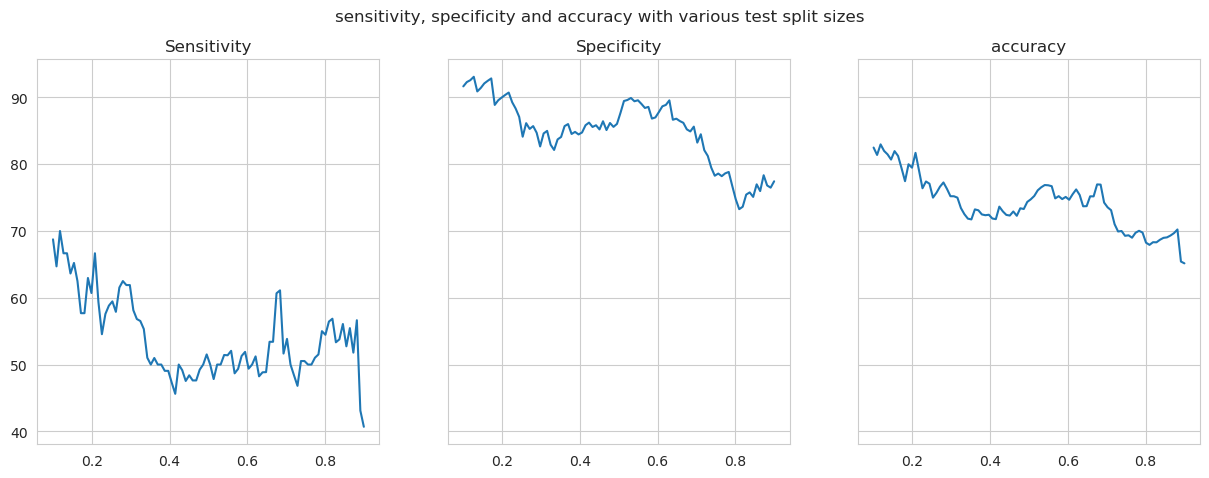

In [46]:
splitplot(knm(7))

with other cluster sizes:

{'max-sensitivity': 60.0, 'split-size': 0.11797752808988765}
{'max-specificity': 100.0, 'split-size': 0.10898876404494383}
{'max-accuracy': 82.97872340425532, 'split-size': 0.11797752808988765}


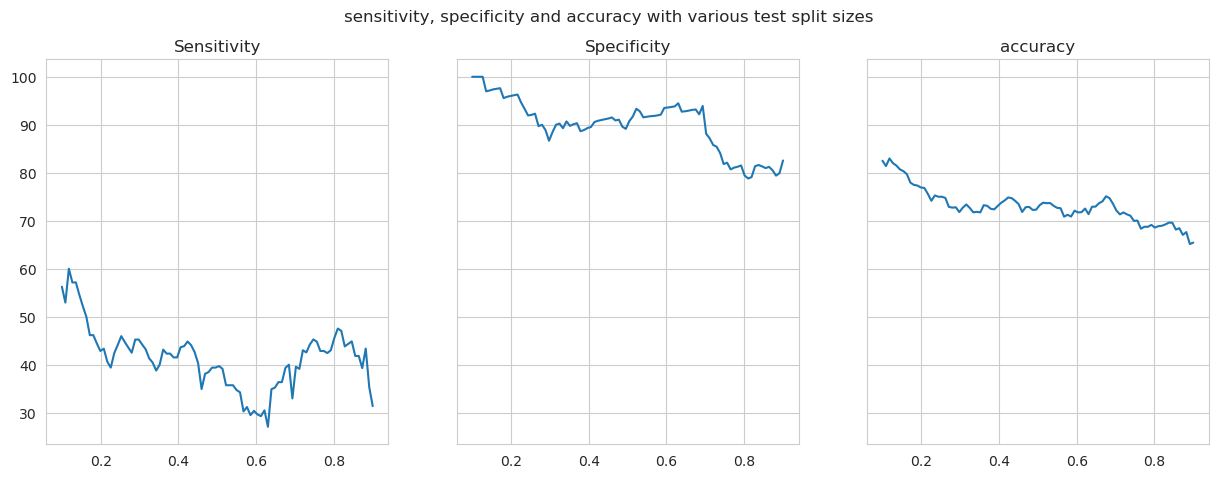

In [47]:
splitplot(knm(6))

{'max-sensitivity': 60.0, 'split-size': 0.11797752808988765}
{'max-specificity': 96.55172413793103, 'split-size': 0.12696629213483146}
{'max-accuracy': 80.85106382978724, 'split-size': 0.11797752808988765}


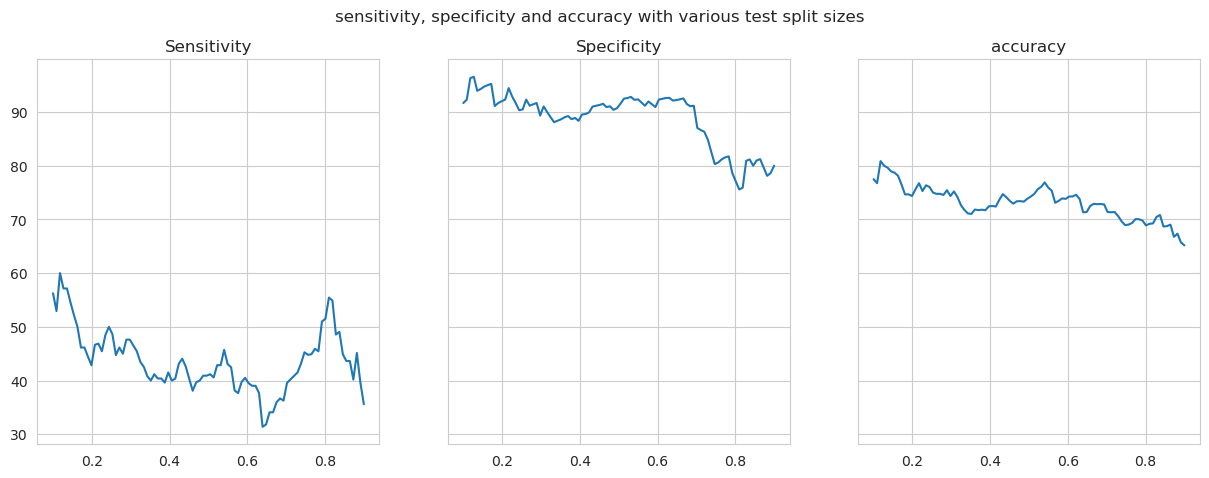

In [48]:
splitplot(knm(8))

I tried some other cluster sizes and got maximum stats for cluster size 7 so far.

{'max-sensitivity': 80.95238095238095, 'split-size': 0.12696629213483146}
{'max-specificity': 100.0, 'split-size': 0.10898876404494383}
{'max-accuracy': 91.48936170212765, 'split-size': 0.11797752808988765}


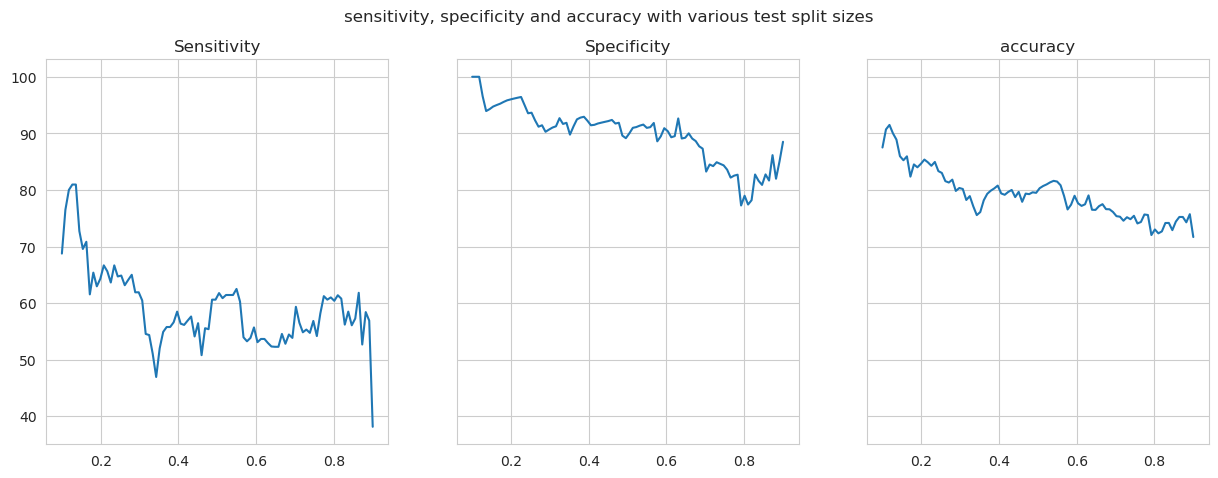

In [50]:
g = splitplot(logreg)

In [51]:
print (g)

[{'max-sensitivity': 80.95238095238095, 'split-size': 0.12696629213483146}, {'max-specificity': 100.0, 'split-size': 0.10898876404494383}, {'max-accuracy': 91.48936170212765, 'split-size': 0.11797752808988765}]


{'max-sensitivity': 80.95238095238095, 'split-size': 0.12696629213483146}
{'max-specificity': 100.0, 'split-size': 0.10898876404494383}
{'max-accuracy': 91.48936170212765, 'split-size': 0.11797752808988765}
{'max-sensitivity': 76.19047619047619, 'split-size': 0.12696629213483146}
{'max-specificity': 100.0, 'split-size': 0.10898876404494383}
{'max-accuracy': 89.36170212765957, 'split-size': 0.11797752808988765}
{'max-sensitivity': 75.0, 'split-size': 0.16292134831460675}
{'max-specificity': 92.5925925925926, 'split-size': 0.21685393258426966}
{'max-accuracy': 83.60655737704919, 'split-size': 0.15393258426966294}
{'max-sensitivity': 85.71428571428571, 'split-size': 0.12696629213483146}
{'max-specificity': 95.23809523809524, 'split-size': 0.17191011235955056}
{'max-accuracy': 90.0, 'split-size': 0.12696629213483146}
{'max-sensitivity': 70.0, 'split-size': 0.11797752808988765}
{'max-specificity': 93.10344827586206, 'split-size': 0.12696629213483146}
{'max-accuracy': 82.97872340425532, 'spl

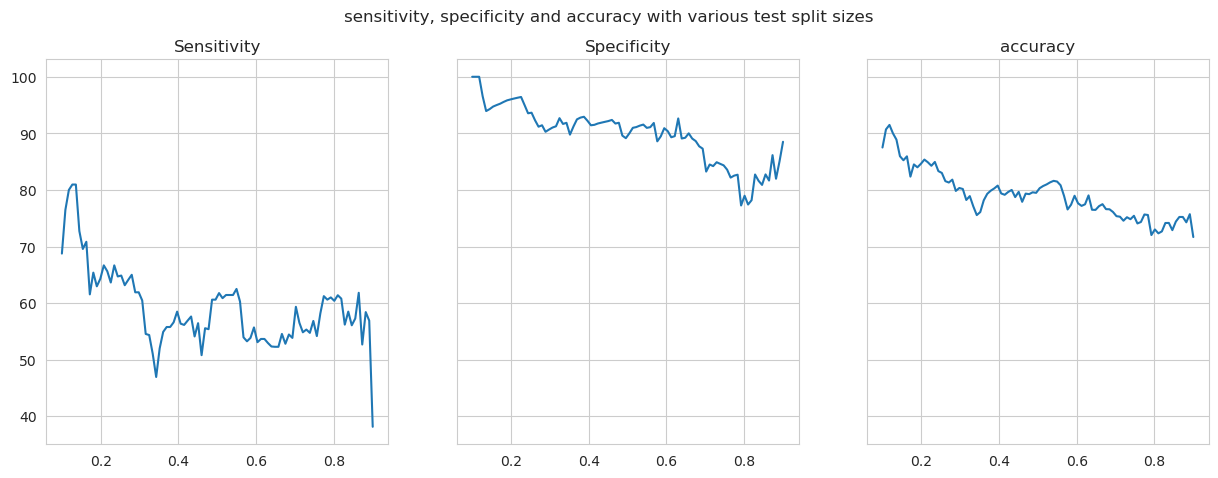

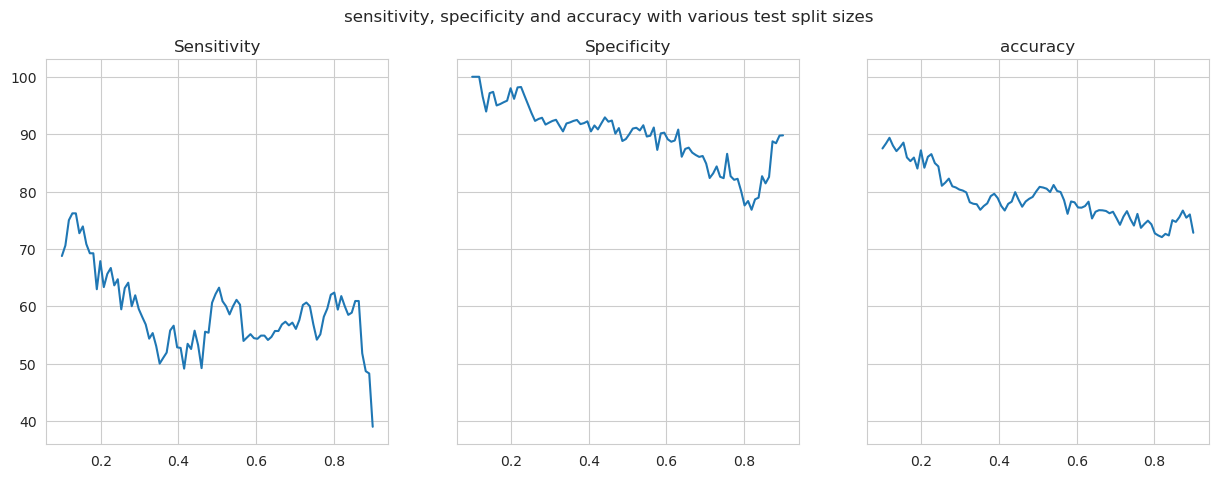

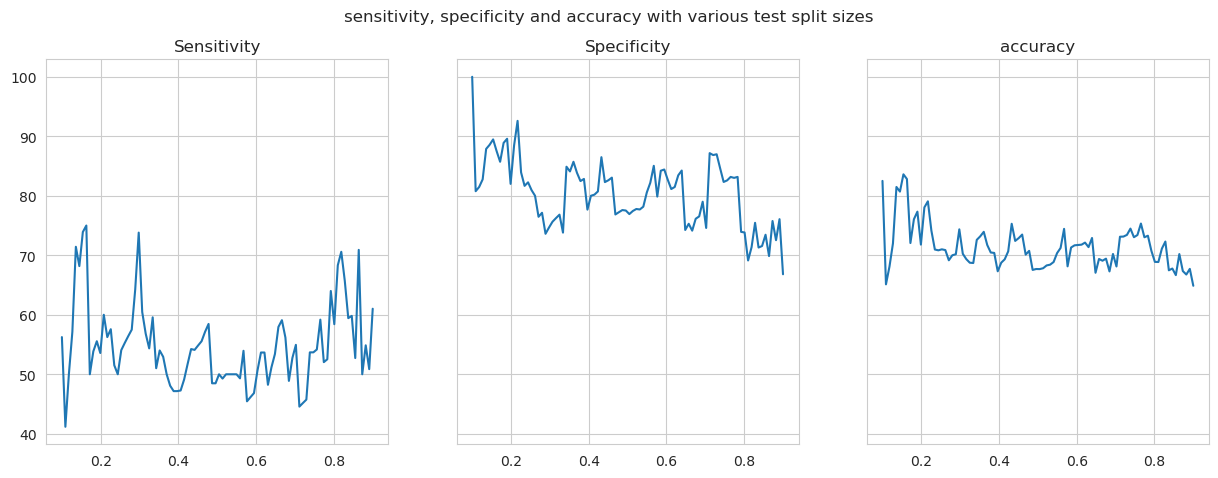

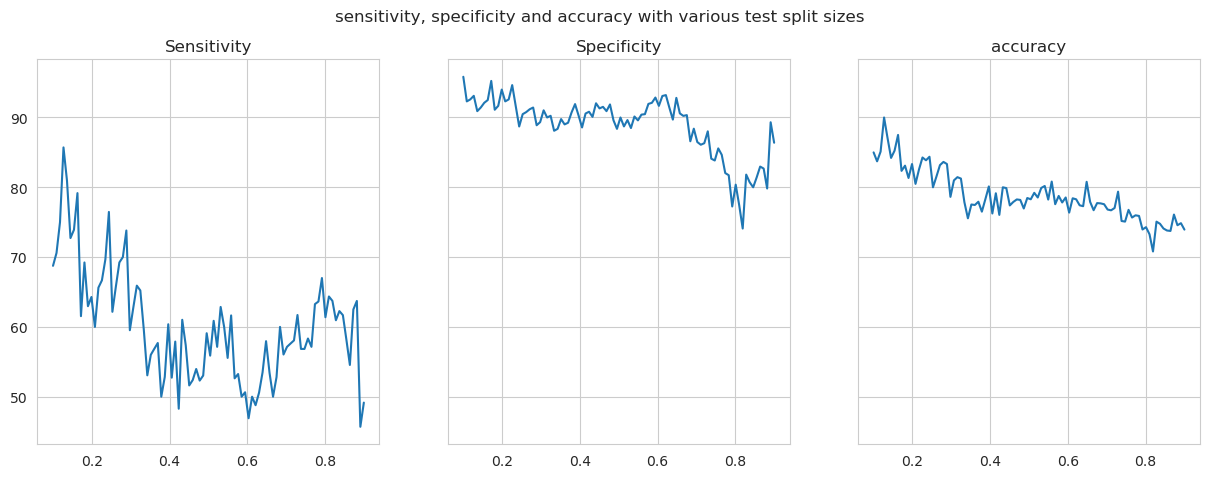

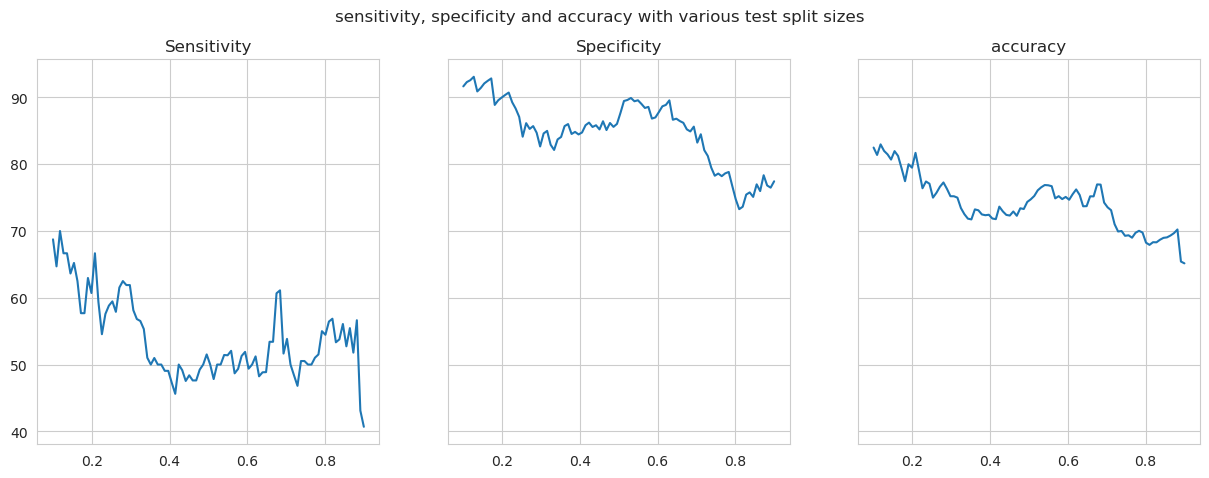

In [54]:
models = np.array(['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'KNN'])
logregstats = splitplot(logreg)
svmstats = splitplot(svmodel)
decisiontreestats = splitplot(dt)
randomforeststats = splitplot(rf)
knnstats = splitplot(knm(7))
overallSensitivity = np.array([logregstats[0]['max-sensitivity'], svmstats[0]['max-sensitivity'], decisiontreestats[0]['max-sensitivity'], randomforeststats[0]['max-sensitivity'],
                               knnstats[0]['max-sensitivity']])
overallspecificity = np.array([logregstats[1]['max-specificity'], svmstats[1]['max-specificity'], decisiontreestats[1]['max-specificity'], randomforeststats[1]['max-specificity'],
                               knnstats[1]['max-specificity']])
overallaccuracy = np.array([logregstats[2]['max-accuracy'], svmstats[2]['max-accuracy'], decisiontreestats[2]['max-accuracy'], randomforeststats[2]['max-accuracy'],
                               knnstats[2]['max-accuracy']])


Text(0.5, 1.0, 'comparison of maximum values of sensitivity, specificity and accuracy of various machine learning models in pima-diabetes dataset')

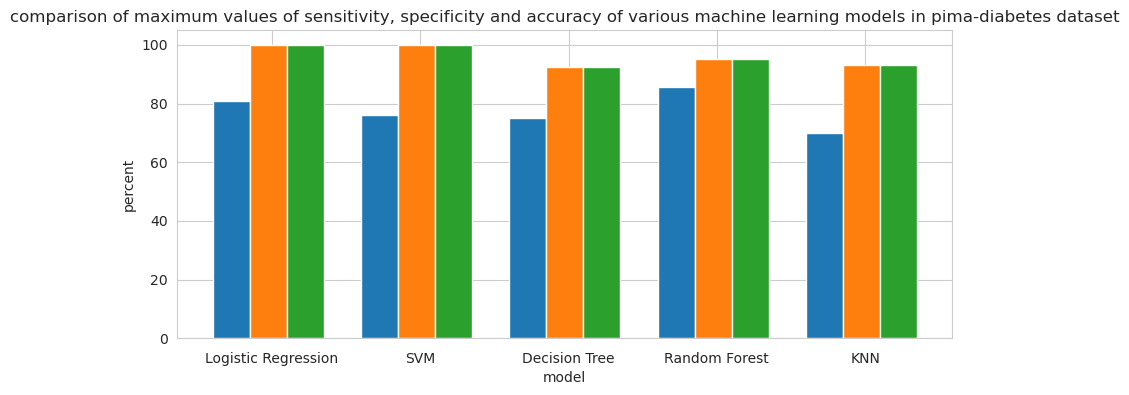

In [84]:
x_axis = np.arange(len(models))
plt.figure(figsize=(10,4))
plt.bar(x_axis, overallSensitivity, 0.25, label = 'sensitivity', align='edge')
plt.bar(x_axis+0.25, overallspecificity, 0.25, label = 'specificity',align='edge')
plt.bar(x_axis+0.5, overallspecificity, 0.25, label = 'accuracy',align='edge') 
plt.xticks(x_axis+0.4, models)
plt.tick_params(axis='x', length=6)
plt.xlabel("model")
plt.ylabel("percent")
plt.title("comparison of maximum values of sensitivity, specificity and accuracy of various machine learning models in pima-diabetes dataset")

Conclusion:

various models tested had different sensitivities, specificities and accuracies at various split sizes. Best of them were at split sizes around 0.11 (i.e 11% test data and 89% train data). A point to be noted is that a row where any column as invalid value (for eg, '0' for Blood Pressure) was eliminated from analysis, shrinking the dataset to almost half. Thus our model might suffer from lack of sufficient data. Best mix of sensitivity, specificity and accuracy was demonstrated by random forest model.